# Este notebook aplica o mesmo método que 01b, mas trocando para base aumentada e filtrada (redução de erros de rótulo) produzida por 02c e o2d2

In [1]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, \
    ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile


from sklearn.metrics import classification_report, confusion_matrix

MODEL_DIR = '../models'
LOG_DIR = '../logs/01b2/'


caminho_bases = os.path.join('..', 'bases', 'vazios_augmented')
caminho_train = os.path.join(caminho_bases, 'train')
caminho_test = os.path.join(caminho_bases, 'test')

# Callbacks

In [7]:
tensorboard_logs = TensorBoard(log_dir=LOG_DIR, histogram_freq=1,
                               write_graph=False, write_images=False,
                               update_freq='epoch')
mcp_save = ModelCheckpoint(os.path.join(MODEL_DIR, 
                                        'B2modelweights.{epoch:02d}-{val_loss:.2f}.hdf5'),
                           save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2,
                              verbose=1, min_delta=1e-2, mode='min')


# Model

In [8]:
SIZE = (224, 224)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3),
                         padding='same',
                         activation='relu',
                         input_shape=(*SIZE, 3)),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(32, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),
  Conv2D(64, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), padding='same', activation='relu'),
#  Conv2D(128, (1, 1), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), activation='relu'),
#  Conv2D(128, (1, 1), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(256, (3, 3), activation='relu'),
#  GlobalAveragePooling2D(),
  Flatten(),
  Dense(256, activation='relu'),
  Dropout(0.4),
  Dense(1, activation='sigmoid')
 
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 64)       

# Training and validation

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    caminho_train,
    target_size=SIZE,
    batch_size=64,
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    caminho_test,
    target_size=SIZE,
    batch_size=32,
    class_mode='binary'
)

Found 61524 images belonging to 2 classes.
Found 4544 images belonging to 2 classes.


In [10]:
epoch = 0

In [5]:
val_loss = 0.13
model.load_weights(
    os.path.join(MODEL_DIR,
                 'Bmodelweights.{:02d}-{:.2f}.hdf5'.format(epoch, val_loss)
                ))

In [11]:
history = model.fit_generator(train_generator,
                               initial_epoch=epoch,
                              epochs=30,
                              verbose=1,
                              callbacks=[early_stop, mcp_save, reduce_lr, tensorboard_logs],
                              validation_data=validation_generator)

Epoch 1/30
962/962 [==============================] - 2347s 2s/step - loss: 0.2360 - acc: 0.9292 - val_loss: 0.1216 - val_acc: 0.9710
Epoch 2/30
962/962 [==============================] - 701s 729ms/step - loss: 0.1487 - acc: 0.9599 - val_loss: 0.1582 - val_acc: 0.9650
Epoch 3/30
961/962 [============================>.] - ETA: 0s - loss: 0.1598 - acc: 0.9628
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
962/962 [==============================] - 200s 208ms/step - loss: 0.1598 - acc: 0.9628 - val_loss: 0.8969 - val_acc: 0.8085
Epoch 4/30
962/962 [==============================] - 194s 202ms/step - loss: 0.1418 - acc: 0.9676 - val_loss: 0.0960 - val_acc: 0.9754
Epoch 5/30
962/962 [==============================] - 194s 202ms/step - loss: 0.1198 - acc: 0.9697 - val_loss: 0.0989 - val_acc: 0.9745
Epoch 6/30
961/962 [============================>.] - ETA: 0s - loss: 0.1199 - acc: 0.9701
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.00000004749

# Evaluation

In [14]:
60 * 64

3840

In [15]:
from utils import get_imagens_erro, report, plot_errors
import time

validation_generator = validation_datagen.flow_from_directory(
    caminho_test,
    target_size=SIZE,
    batch_size=64,
    class_mode='binary',
    shuffle=False
)
s = len(validation_generator) * 64
t0 = time.time()
y_test, y_pred, X_names_test, y_pred_proba = get_imagens_erro(validation_generator, model)
elapsed = time.time() - t0
print('%d imagens processadas em %s segundos (%s por imagem)' % (s, elapsed, elapsed / s))

Found 4544 images belonging to 2 classes.
4544 imagens processadas em 10.920859098434448 segundos (0.0024033580762399752 por imagem)


In [16]:
report(validation_generator, y_test, y_pred)

{0: 'nvazio', 1: 'vazio'}
R/P 	 nvazio 	 vazio 
nvazio 	 2112 	 132
vazio 	 2 	 2298
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      2244
         1.0       0.95      1.00      0.97      2300

    accuracy                           0.97      4544
   macro avg       0.97      0.97      0.97      4544
weighted avg       0.97      0.97      0.97      4544



{0: 'nvazio', 1: 'vazio'}


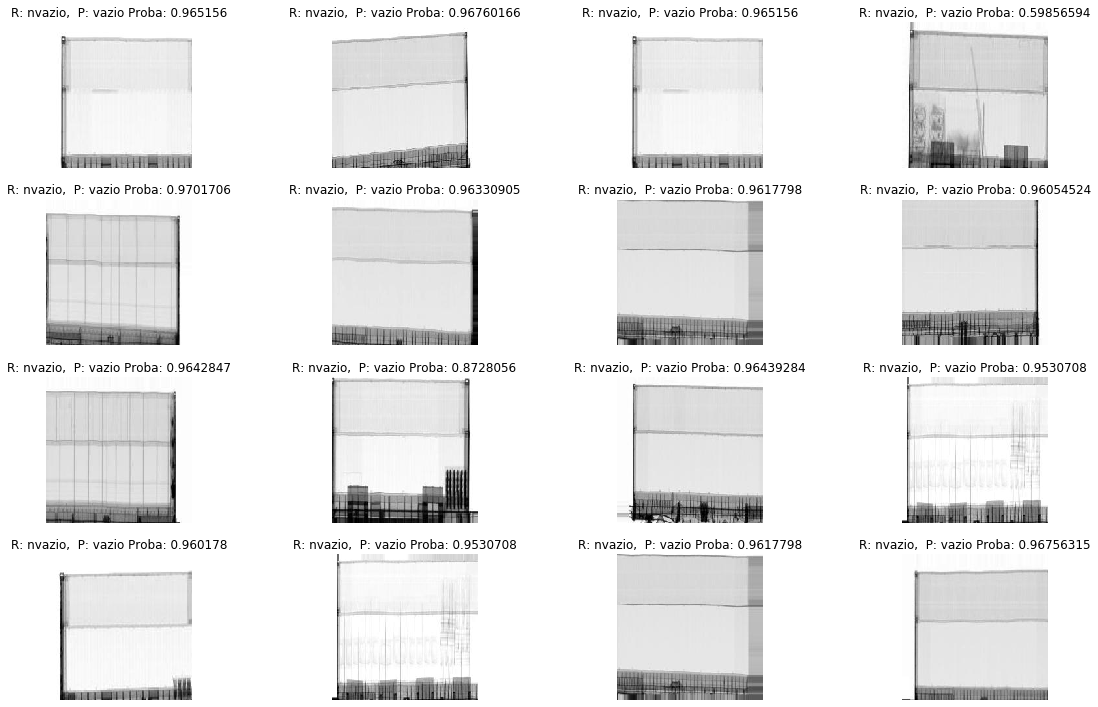

In [17]:
from utils import plot_errors
plot_errors(validation_generator, y_test, y_pred, caminho_test, X_names_test, y_pred_proba)

In [23]:
train_generator = train_datagen.flow_from_directory(
    caminho_train,
    target_size=SIZE,
    batch_size=128,
    class_mode='binary',
    shuffle=False
)

s = len(validation_generator) * 128
t0 = time.time()

y_train, y_pred_train, X_names_train, y_pred_train_proba = get_imagens_erro(train_generator, model)

elapsed = time.time() - t0
print('%d imagens processadas em %s segundos (%s por imagem)' % (s, elapsed, elapsed / s))

Found 61524 images belonging to 2 classes.
9088 imagens processadas em 147.3080039024353 segundos (0.016209067330813745 por imagem)


In [24]:
report(train_generator, y_train, y_pred_train)

{0: 'nvazio', 1: 'vazio'}
R/P 	 nvazio 	 vazio 
nvazio 	 28403 	 2095
vazio 	 5 	 31021
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     30498
         1.0       0.94      1.00      0.97     31026

    accuracy                           0.97     61524
   macro avg       0.97      0.97      0.97     61524
weighted avg       0.97      0.97      0.97     61524



{0: 'nvazio', 1: 'vazio'}


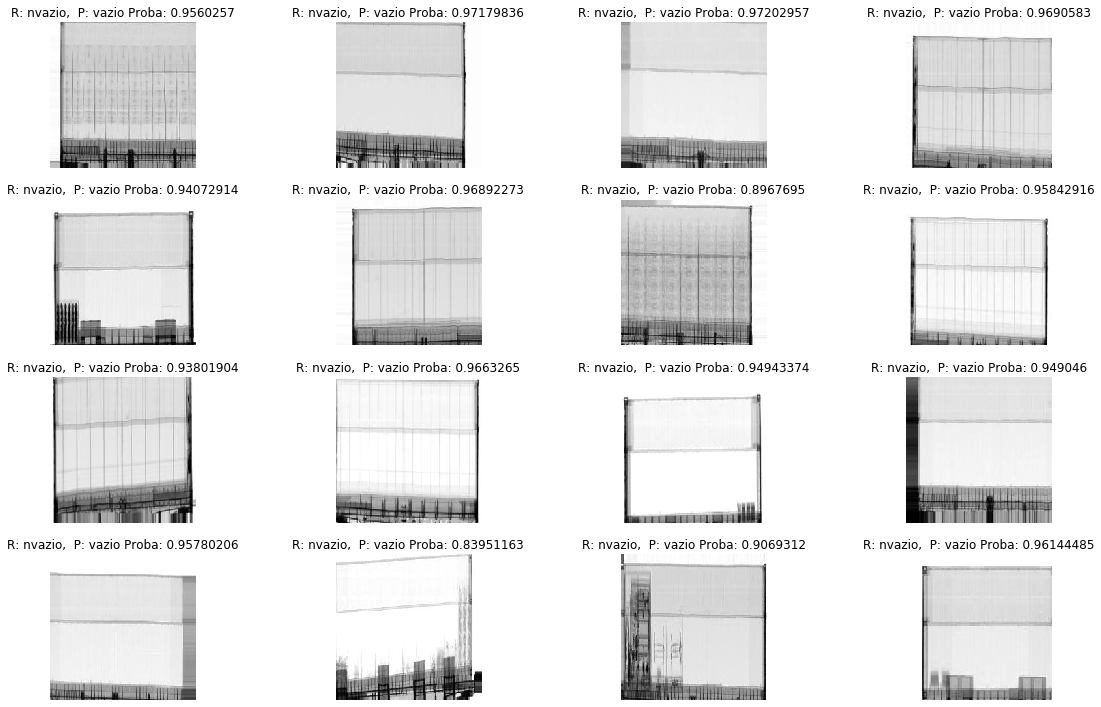

In [26]:
plot_errors(train_generator, y_train, y_pred_train, caminho_train, X_names_train, y_pred_train_proba)

# Tunning

In [28]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['acc'])


In [29]:
epoch = 4
val_loss = 0.10
model.load_weights(
    os.path.join(MODEL_DIR,
                 'B2modelweights.{:02d}-{:.2f}.hdf5'.format(epoch, val_loss)
                ))

In [30]:
history = model.fit_generator(train_generator,
                               initial_epoch=epoch,
                              epochs=30,
                              verbose=1,
                              callbacks=[early_stop, mcp_save, reduce_lr, tensorboard_logs],
                              validation_data=validation_generator)

Epoch 5/30
481/481 [==============================] - 220s 458ms/step - loss: 0.1186 - acc: 0.9697 - val_loss: 0.0973 - val_acc: 0.9756
Epoch 6/30
481/481 [==============================] - 201s 418ms/step - loss: 0.1139 - acc: 0.9703 - val_loss: 0.0942 - val_acc: 0.9767
Epoch 7/30
480/481 [============================>.] - ETA: 0s - loss: 0.1135 - acc: 0.9708
Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
481/481 [==============================] - 201s 418ms/step - loss: 0.1132 - acc: 0.9708 - val_loss: 0.0943 - val_acc: 0.9760
Epoch 8/30
481/481 [==============================] - 197s 410ms/step - loss: 0.1101 - acc: 0.9710 - val_loss: 0.0938 - val_acc: 0.9762
Epoch 9/30
480/481 [============================>.] - ETA: 0s - loss: 0.1093 - acc: 0.9712
Epoch 00009: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
481/481 [==============================] - 203s 423ms/step - loss: 0.1092 - acc: 0.9712 - val_loss: 0.0939 - val_acc: 0.9765


# Testar na base original!!!
### ( sem transformações )

In [43]:
caminho_basest = os.path.join('..', 'bases', 'vazios')
caminho_traint = os.path.join(caminho_basest, 'train')
caminho_testt = os.path.join(caminho_basest, 'test')

In [44]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

validation_generator = validation_datagen.flow_from_directory(
    caminho_testt,
    target_size=SIZE,
    batch_size=64,
    class_mode='binary',
    shuffle=False
)
s = len(validation_generator) * 64
t0 = time.time()
y_test, y_pred, X_names_test, y_pred_proba = get_imagens_erro(validation_generator, model)
elapsed = time.time() - t0
print('%d imagens processadas em %s segundos (%s por imagem)' % (s, elapsed, elapsed / s))

Found 2317 images belonging to 2 classes.
2368 imagens processadas em 7.969754457473755 segundos (0.0033656057675142547 por imagem)


In [45]:
report(validation_generator, y_test, y_pred)

{0: 'nvazio', 1: 'vazio'}
R/P 	 nvazio 	 vazio 
nvazio 	 1069 	 97
vazio 	 0 	 1151
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      1166
         1.0       0.92      1.00      0.96      1151

    accuracy                           0.96      2317
   macro avg       0.96      0.96      0.96      2317
weighted avg       0.96      0.96      0.96      2317



{0: 'nvazio', 1: 'vazio'}


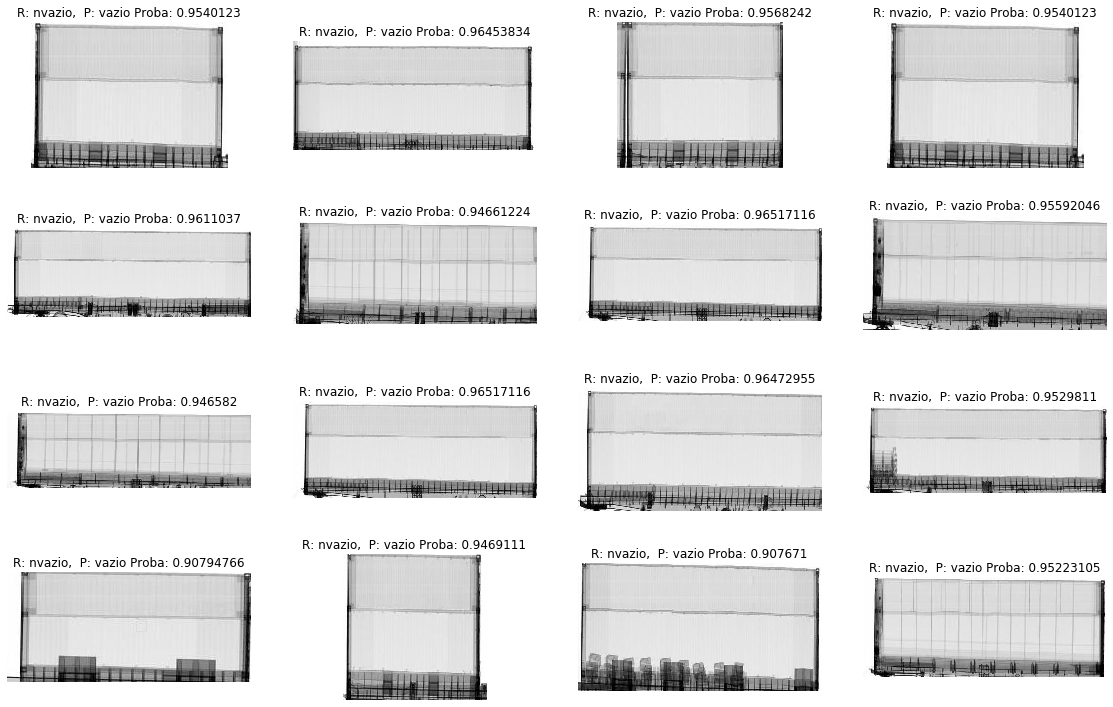

In [47]:
plot_errors(validation_generator, y_test, y_pred, caminho_testt, X_names_test, y_pred_proba)

In [48]:
train_generator = train_datagen.flow_from_directory(
    caminho_traint,
    target_size=SIZE,
    batch_size=128,
    class_mode='binary',
    shuffle=False
)

s = len(train_generator) * 128
t0 = time.time()

y_train, y_pred_train, X_names_train, y_pred_train_proba = get_imagens_erro(train_generator, model)

elapsed = time.time() - t0
print('%d imagens processadas em %s segundos (%s por imagem)' % (s, elapsed, elapsed / s))

Found 20845 images belonging to 2 classes.
20864 imagens processadas em 71.28133487701416 segundos (0.0034164750228630253 por imagem)


In [49]:
report(train_generator, y_train, y_pred_train)

{0: 'nvazio', 1: 'vazio'}
R/P 	 nvazio 	 vazio 
nvazio 	 9580 	 914
vazio 	 1 	 10350
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95     10494
         1.0       0.92      1.00      0.96     10351

    accuracy                           0.96     20845
   macro avg       0.96      0.96      0.96     20845
weighted avg       0.96      0.96      0.96     20845



{0: 'nvazio', 1: 'vazio'}


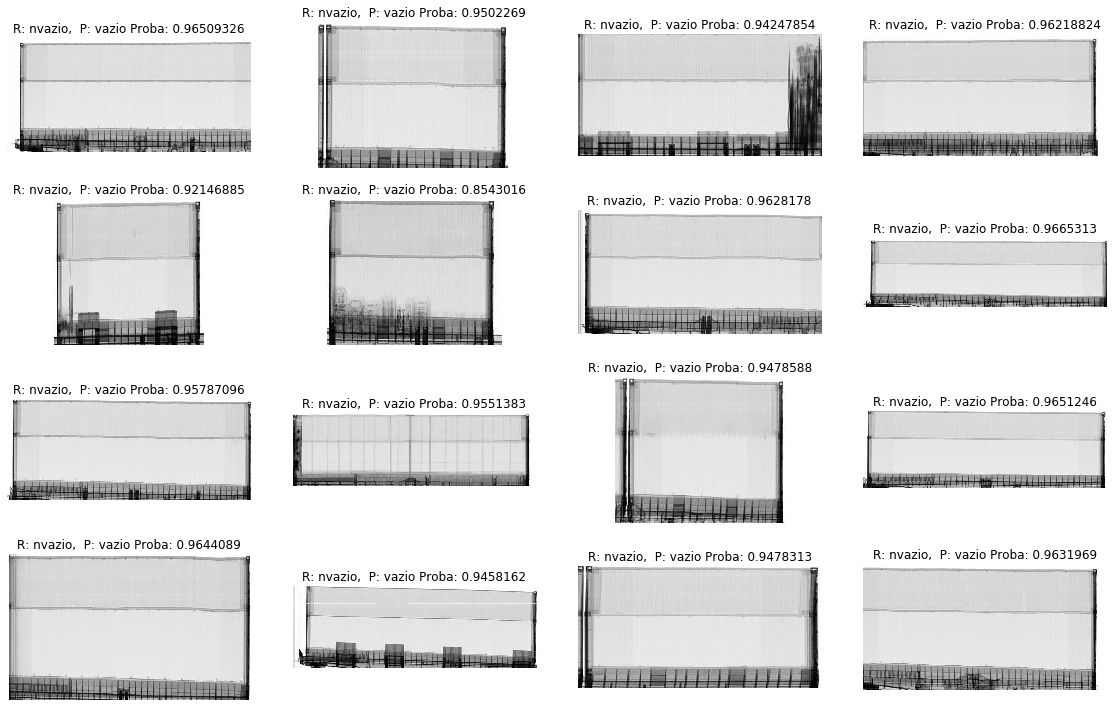

In [51]:
plot_errors(train_generator, y_train, y_pred_train, caminho_traint, X_names_train, y_pred_train_proba)

In [37]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from tensorflow.keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0

    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

In [40]:
get_model_memory_usage(1, model)

0.014